# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [10]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/HW1/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL/HW1


## ⚙️ Import Libraries

In [6]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


## ⏳ Load the Data and PreProcess


In [11]:
# Load the training data here
data_path = '/gdrive/My Drive/AN2DL/HW1/unique_images.npz'
data = np.load(data_path)

images = data['images']
labels = data['labels']

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (11952, 96, 96, 3)
Labels shape: (11952, 1)


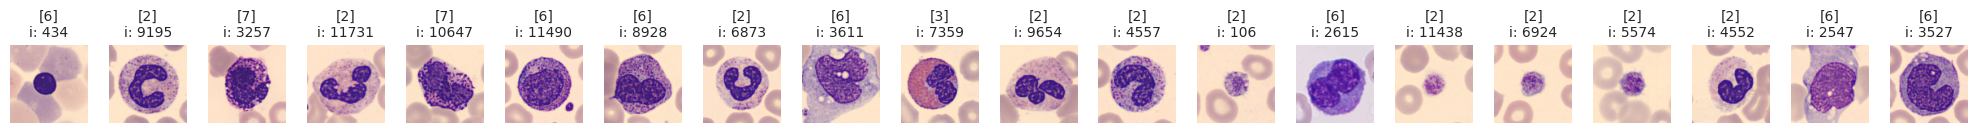

In [85]:
# Display a sample of images from the training-validation dataset
num_img = 20
random_indices = random.sample(range(len(images)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(images[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[labels[idx][0]]}\ni: {random_indices[i]}', fontsize=10)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

##PRE PROCESS

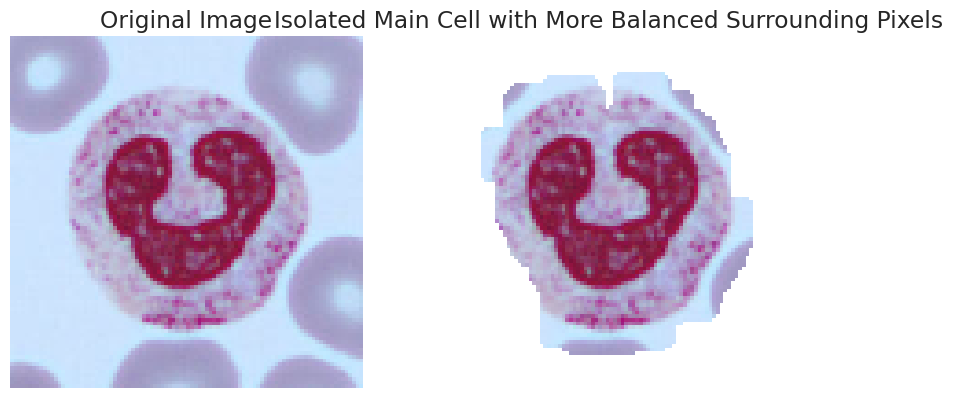

In [90]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the image
image = images[6873]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to the HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define lower and upper bounds for the violet color (softer threshold)
lower_violet = np.array([120, 5, 50])   # Adjusted to include more subtle violet tones
upper_violet = np.array([210, 215, 180])

# Create a mask for the violet color
mask = cv2.inRange(hsv_image, lower_violet, upper_violet)

# Apply Gaussian blur to smooth the mask edges
mask = cv2.GaussianBlur(mask, (7, 7), 0)

# Define a smaller kernel for morphological operations to avoid over-expansion
small_kernel = np.ones((5, 5), np.uint8)  # Smaller kernel for dilation

# Apply erosion and dilation with fewer iterations
mask = cv2.erode(mask, small_kernel, iterations=1)  # Erode once
mask = cv2.dilate(mask, small_kernel, iterations=3)  # Dilate a bit more, but not too much

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the largest contour, assuming it's the main cell
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    # Create a new mask with only the largest contour
    cell_mask = np.zeros_like(mask)
    cv2.drawContours(cell_mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    # Apply the mask to the original image to isolate the main cell
    isolated_cell = cv2.bitwise_and(image_rgb, image_rgb, mask=cell_mask)

    # Convert masked area outside the main cell to white
    output_image = isolated_cell.copy()
    output_image[cell_mask == 0] = [255, 255, 255]

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Isolated Main Cell with More Balanced Surrounding Pixels")
plt.imshow(output_image)
plt.axis("off")

plt.show()

In [91]:
import numpy as np
import cv2

# Assuming 'images' is a list of images (already loaded)

# Create a list to store the processed images
processed_images = []

# Define lower and upper bounds for the violet color (softer threshold)
lower_violet = np.array([120, 5, 50])  # Adjusted to include more subtle violet tones
upper_violet = np.array([200, 205, 190])

# Define a smaller kernel for morphological operations to avoid over-expansion
small_kernel = np.ones((5, 5), np.uint8)  # Smaller kernel for dilation

# Process each image in the dataset
for img in images:
    # Convert the image to RGB (if necessary)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Create a mask for the violet color
    mask = cv2.inRange(hsv_image, lower_violet, upper_violet)

    # Apply Gaussian blur to smooth the mask edges
    mask = cv2.GaussianBlur(mask, (7, 7), 0)

    # Apply erosion and dilation with fewer iterations
    mask = cv2.erode(mask, small_kernel, iterations=1)  # Erode once
    mask = cv2.dilate(mask, small_kernel, iterations=3)  # Dilate a bit more, but not too much

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the largest contour, assuming it's the main cell
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        # Create a new mask with only the largest contour
        cell_mask = np.zeros_like(mask)
        cv2.drawContours(cell_mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

        # Apply the mask to the original image to isolate the main cell
        isolated_cell = cv2.bitwise_and(image_rgb, image_rgb, mask=cell_mask)

        # Convert masked area outside the main cell to white
        output_image = isolated_cell.copy()
        output_image[cell_mask == 0] = [255, 255, 255]

        # Append the processed image to the list
        processed_images.append(output_image)

# Save the processed images as a .npz file
np.savez('threshold.npz', processed_images=np.array(processed_images))

In [97]:
# Load the training data here
data_path = '/gdrive/My Drive/AN2DL/HW1/threshold.npz'
data = np.load(data_path)

images = data['processed_images']


print("Images shape:", images.shape)


Images shape: (11952, 96, 96, 3)


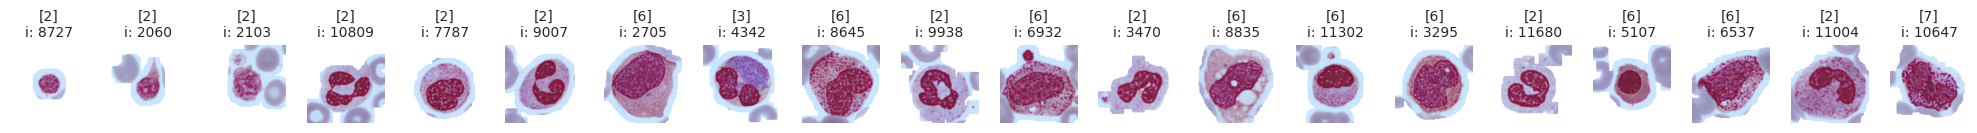

In [106]:
# Display a sample of images from the training-validation dataset
num_img = 20
random_indices = random.sample(range(len(images)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(images[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[labels[idx][0]]}\ni: {random_indices[i]}', fontsize=10)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()